<center style="font-weight:bold;font-size:26px">Pericolo - Warp Perspective - Vanishing Points</center>

# Setup

## Imports

In [1]:
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, color, transform, io

In [3]:
from PIL import Image, ImageDraw

In [4]:
sys.path.append(os.path.join(os.path.abspath(''), '.'))

## Global Variables

In [5]:
ROOT_FOLDER = os.path.join(os.path.abspath(''), '..') # Project Folder
DATA_FOLDER = os.path.join(ROOT_FOLDER, 'data') # Data Folder
VP_IMG_FOLDER = os.path.join(DATA_FOLDER, 'vpimg') # Image folder for vanishing points
IMG_FOLDER = os.path.join(DATA_FOLDER, 'img') # Image folder
ANNOT_FOLDER = os.path.join(DATA_FOLDER, 'annotations') # XML folder

# Functions definition

## Auto-rectification functions

In [6]:
def generate_edges(image, sigma=3):
    gray_img = color.rgb2gray(image) # Convert RGB to GrayScale
    edges = feature.canny(gray_img, sigma=sigma) # Edges Coarse detection
    lines = transform.probabilistic_hough_line(edges, line_length=3, line_gap=2) # Generate potential lines from edges
    return gray_img, edges, lines

In [7]:
def vector_representation(lines):
    locations = []
    directions = []
    strengths = []
    
    # For each detected line of 2 points
    for a,b in lines:
        a,b = np.array(a), np.array(b)
        locations.append((a + b) / 2) # generate the location as the middle point
        directions.append(b - a) # compute the direction vector
        strengths.append(np.linalg.norm(b - a)) # compute the strength as the norm
    
    locations = np.array(locations)
    directions = np.array(directions)
    strengths = np.array(strengths)
    
    directions = np.array(directions) / np.linalg.norm(directions, axis=1)[:, np.newaxis] # normalize the directions
    
    return (locations, directions, strengths)

In [8]:
def to_homogenous_geometry(locations, directions, strengths):
    normals = np.zeros_like(directions) # Compute the edglets normal vector
    normals[:, 0] = directions[:, 1]
    normals[:, 1] = -directions[:, 0]
    p = -np.sum(locations * normals, axis=1)
    lines = np.concatenate((normals, p[:, np.newaxis]), axis=1) # Create the 3rd dimension representing the same point
    return lines

In [9]:
def ransac(locations, directions, strengths, num_ransac_iter=2000, threshold_inlier=5):
    lines = to_homogenous_geometry(locations, directions, strengths) # convert to homogenous geometry

    num_pts = strengths.size

    arg_sort = np.argsort(-strengths)
    first_index_space = arg_sort[:num_pts // 5] # Select the top 20 percentile
    second_index_space = arg_sort[:num_pts // 2] # Select the top 50 percentile

    best_model = None
    best_votes = np.zeros(num_pts)

    # Sampling process
    for ransac_iter in range(num_ransac_iter):
        ind1 = np.random.choice(first_index_space) # Sample a line from the top 20 percentile
        ind2 = np.random.choice(second_index_space) # Sample a line from the top 50 percentile

        l1 = lines[ind1]
        l2 = lines[ind2]

        # In Homogenous geometry the cross-product (vectot product)
        # represents the intersection points between two vectors
        current_model = np.cross(l1, l2)
        
        # In case of degeneracy
        # e.g colinearity between l1 and l2
        # e.g sampling where l1 and l2 are the same line
        if np.sum(current_model**2) < 1 or current_model[2] == 0:
            # Force resampling
            continue

        # Represent Vanishing Point (Intersection Point) in (X, Y, 1) Initial Plane
        vp = current_model[:2] / current_model[2]
        
        # For each edgelet compute the angle between the direction vector
        # and the vector defined as edgelet location minus vanishing point
        est_directions = locations - vp
        dot_prod = np.sum(est_directions * directions, axis=1)
        abs_prod = np.linalg.norm(directions, axis=1) * np.linalg.norm(est_directions, axis=1)
        abs_prod[abs_prod == 0] = 1e-5
        threshold_inlier = 5
        cosine_theta = dot_prod / abs_prod
        theta = np.arccos(np.abs(cosine_theta))
        
        # Consider for scoring only the edglets within a range of +/- threshold_inlier
        theta_thresh = threshold_inlier * np.pi / 180
        # The score is equal to the sum of edgelet's strength falling in the threshold range
        current_votes = (theta < theta_thresh) * strengths
        
        # In case the new model is better, replace the old one
        if current_votes.sum() > best_votes.sum():
            best_model = current_model
            best_votes = current_votes
            print("Current best model has {} votes at iteration {}".format(
                current_votes.sum(), ransac_iter))
    return best_model

In [10]:
def remove_compliant_edgelets(vanishing_point, locations, directions, strengths, threshold_inlier=10):
    # See above for scoring description
    vp = vanishing_point[:2] / vanishing_point[2]
    est_directions = locations - vp
    dot_prod = np.sum(est_directions * directions, axis=1)
    abs_prod = np.linalg.norm(directions, axis=1) * np.linalg.norm(est_directions, axis=1)
    abs_prod[abs_prod == 0] = 1e-5
    threshold_inlier = 5
    cosine_theta = dot_prod / abs_prod
    theta = np.arccos(np.abs(cosine_theta))
    theta_thresh = threshold_inlier * np.pi / 180
    
    # Define each edgelet falling under the threshold range as 1 
    compliant_indices = ((theta < theta_thresh) * strengths) > 0
    
    # Remove each edgelet falling under the threshold range
    locations = locations[~compliant_indices]
    directions = directions[~compliant_indices]
    strengths = strengths[~compliant_indices]
    return (locations, directions, strengths)

In [11]:
def warp_image(image, vp1, vp2, clip=True, clip_factor=3):
    # PARALLEL LINES RESTORATION MATRIX
    # Correspond to matrix H in the paper
    # Pushing the vanishing points to infinity
    vanishing_line = np.cross(vp1, vp2)
    H = np.eye(3)
    H[2] = vanishing_line / vanishing_line[2]
    H = H / H[2, 2]

    
    # VERTICAL ALIGNEMENT MATRIX
    # Rotation to align the vertical vanishing point with the Y Axis
    # Corresponds to R matrix in the paper
    
    # Find directions corresponding to vanishing points
    v_post1 = np.dot(H, vp1)
    v_post2 = np.dot(H, vp2)
    v_post1 = v_post1 / np.sqrt(v_post1[0]**2 + v_post1[1]**2)
    v_post2 = v_post2 / np.sqrt(v_post2[0]**2 + v_post2[1]**2)

    directions = np.array([[v_post1[0], -v_post1[0], v_post2[0], -v_post2[0]],
                           [v_post1[1], -v_post1[1], v_post2[1], -v_post2[1]]])

    thetas = np.arctan2(directions[0], directions[1])

    # Find direction closest to horizontal axis
    h_ind = np.argmin(np.abs(thetas))

    # Find positve angle among the rest for the vertical axis
    if h_ind // 2 == 0:
        v_ind = 2 + np.argmax([thetas[2], thetas[3]])
    else:
        v_ind = np.argmax([thetas[2], thetas[3]])

    A1 = np.array([[directions[0, v_ind], directions[0, h_ind], 0],
                   [directions[1, v_ind], directions[1, h_ind], 0],
                   [0, 0, 1]])
    
    # Might be a reflection. If so, remove reflection.
    if np.linalg.det(A1) < 0:
        A1[:, 0] = -A1[:, 0]

    A = np.linalg.inv(A1)

    # OVERALL HOMOGRAPHY
    # Corresponds to the T matrix in the paper
    inter_matrix = np.dot(A, H)

    
    # Cropping
    
    # Create a 4x3 matrix corresponding to the edges of the source image
    # The last dimension are set to 1 to describe the initial plane
    image_edges = [
        [0, 0, image.shape[1], image.shape[1]],
        [0, image.shape[0], 0, image.shape[0]],
        [1, 1, 1, 1]
    ]
    
    # Matrix multiplication to define the new coordinates of the edges
    cords = np.dot(inter_matrix, image_edges)
    
    # Describe those coordinates in the initial plane
    cords = cords[:2] / cords[2]

    # Check if some coordinates lie outside of the image
    tx = min(0, cords[0].min())
    ty = min(0, cords[1].min())

    # Augment the maximum shape to cover the whole image
    max_x = cords[0].max() - tx
    max_y = cords[1].max() - ty

    if clip:
        # These might be too large. Clip them.
        max_offset = max(image.shape) * clip_factor / 2
        tx = max(tx, -max_offset)
        ty = max(ty, -max_offset)

        max_x = min(max_x, -tx + max_offset)
        max_y = min(max_y, -ty + max_offset)

    max_x = int(max_x)
    max_y = int(max_y)

    # Create an Offset matrix
    T = np.array([[1, 0, -tx],
                  [0, 1, -ty],
                  [0, 0, 1]])

    # Generate the final Homography matrix
    # by applying the offset on top of the previous matrices
    final_homography = np.dot(T, inter_matrix)

    # Generate the transformed image
    warped_img = transform.warp(image, np.linalg.inv(final_homography),
                                output_shape=(max_y, max_x))
    return warped_img

## Plot functions

In [12]:
def imshow(img, figsize=(6, 6)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

# Bibliography & Documentation

## Introduction

The following notebook is an implementation of **AUTO-RECTIFICATION OF USER PHOTOS** by _Krishnendu Chaudhury_ , _Stephen DiVerdi_ , _Sergey Ioffe_. Some modifications are applied to make the code more computational efficient.

[Link to the publication](https://static.googleusercontent.com/media/research.google.com/fr//pubs/archive/42532.pdf)

Before you dive into the code, you might need some material to understand how this algorithm works. First of all, this algorithm involves basic **linear algebra** but also more mathematical concepts such as **homogenous mathematics**.

<span style="font-size:20px">**Homogenous coordinates**</span>

In mathematics, homogeneous coordinates or projective coordinates are a system of coordinates used in projective geometry, as Cartesian coordinates are used in Euclidean geometry. They have the advantage that the coordinates of points, including points at infinity, can be represented using finite coordinates. Homogeneous coordinates have a range of applications, including computer graphics and 3D computer vision, where they allow affine transformations and, in general, projective transformations to be easily represented by a matrix.

If the homogeneous coordinates of a point are multiplied by a non-zero scalar then the resulting coordinates represent the same point. Since homogeneous coordinates are also given to points at infinity, the number of coordinates required to allow this extension is one more than the dimension of the projective space being considered. For example, two homogeneous coordinates are required to specify a point on the projective line and three homogeneous coordinates are required to specify a point in the projective plane.

<img src="../doc/img/homogenous_points.png" alt="drawing" width="400"/>

The real projective plane can be thought of as the Euclidean plane with additional points added, which are called points at infinity, and are considered to lie on a new line, the line at infinity. There is a point at infinity corresponding to each direction (numerically given by the slope of a line), informally defined as the limit of a point that moves in that direction away from the origin. Parallel lines in the Euclidean plane are said to intersect at a point at infinity corresponding to their common direction. Given a point $(x, y)$ on the Euclidean plane, for any non-zero real number $Z$, the triple $(xZ, yZ, Z)$ is called a set of homogeneous coordinates for the point. By this definition, multiplying the three homogeneous coordinates by a common, non-zero factor gives a new set of homogeneous coordinates for the same point. In particular, $(x, y, 1)$ is such a system of homogeneous coordinates for the point $(x, y)$. For example, the Cartesian point $(1, 2)$ can be represented in homogeneous coordinates as $(1, 2, 1)$ or $(2, 4, 2)$. The original Cartesian coordinates are recovered by dividing the first two positions by the third. Thus unlike Cartesian coordinates, a single point can be represented by infinitely many homogeneous coordinates.

The equation of a line through the origin $(0, 0)$ may be written $nx + my = 0$ where $n$ and $m$ are not both $0$. In parametric form this can be written $x = mt$, $y = −nt$. Let $Z = 1/t$, so the coordinates of a point on the line may be written $(m/Z, −n/Z)$. In homogeneous coordinates this becomes $(m, −n, Z)$. In the limit, as $t$ approaches infinity, in other words, as the point moves away from the origin, $Z$ approaches $0$ and the homogeneous coordinates of the point become $(m, −n, 0)$. Thus we define $(m, −n, 0)$ as the homogeneous coordinates of the point at infinity corresponding to the direction of the line $nx + my = 0$. As any line of the Euclidean plane is parallel to a line passing through the origin, and since parallel lines have the same point at infinity, the infinite point on every line of the Euclidean plane has been given homogeneous coordinates.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Homogeneous_coordinates#/media/File:RationalBezier2D.svg)

## Algorithm

### Edge Detection

The first step is to detect the potential lines in the image. To do so, we convert our input image (RGB/BGR) to GrayScale. On the GRAYSCALE image we can apply a **Canny Edge Detection**. On the defined edges, we apply a **Probabilistic Hough Transform** to infer the position and extremums of the potential lines in the image.

**Bibliography:**
* _Canny Edge Detection_
    * [Technical interpretation](https://en.wikipedia.org/wiki/Canny_edge_detector)
    * [OpenCV documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html)
    * [Scikit-image documentation](https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html)
* _Hough Transform_
    * [Technical interpretation](https://en.wikipedia.org/wiki/Hough_transform)
    * [OpenCV documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)
    * [Scikit-image documentation](https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html)

We first convert our colored Input Image $I$ _(RGB or BGR)_ ,
<img src="../doc/img/source_sample.png" alt="drawing" width="400"/>
To a grayscale image $G$,
<img src="../doc/img/gray_sample.png" alt="drawing" width="400"/>
We then apply **Canny Edge Detection**,
<img src="../doc/img/canny_sample.png" alt="drawing" width="400"/>
And **Hough Transform** to obtain the _edgelets_ *
<img src="../doc/img/edgelets_sample.png" alt="drawing" width="400"/>

Notes: (*) Edgelets are described below

## Conversion from Euclidean geometry to Homogenous geometry

> An edgelet is an abstract entity, attached to each edge point
> of the image, with 3 properties: (i) edge location (the image
> coordinates of the edge point) (ii) edge direction (unit vector
> along the edge) (iii) edge strength

**<div style="text-align: right"> AUTO-RECTIFICATION OF USER PHOTOS, K.Chaudhury , S.DiVerdi , S.Ioffe </div>**

In Euclidean geometry, a line is represented by two points $A$, $B$ with their respective scalar coordinates $(x_A, y_A)$, $(x_B, y_B)$, or by an origin point $C$ and a direction vector $\vec{u}$. In Homogenous geometry, an **Edgelet** $E$ will be represented as follow $E = \{\vec{x}, \vec{d}, s\}$ with $\vec{x}$ the homogenous representation of an edglet point, $\vec{d}$ the edge direction and $s$ the edgelet strength

## RANSAC - Model Selection

> Random sample consensus **(RANSAC)** is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers, when outliers are to be accorded no influence on the values of the estimates.

[<div style="text-align: right">Wikipedia</div>](https://en.wikipedia.org/wiki/Random_sample_consensus)

In the case of vanishing point detection, our RANSAC algorithm samples the previously detected edgelets to find the best vanishing point possible _(BVP)_. This BVP is the vanishing point that explains where the strongest edgelets meet. To determine which vanishing point is the best, we use a score function that we expect to maximize over random sampling.

To sum up the RANSAC algorithm acts as follow:
- For X steps do:
    1. Sample two edgelets _(resp.)_ from the first 20 and 50 percentile (edgelets ordered by strengths)
    2. Generate the vanishing point, corresponding to the intersection point of the 2 previously sampled edgelets
    3. **Compute the score of this vanishing point to explain all edgelets**
    4. Check if the score is the highest we found
        - If this is **True**, it means this current vanishing point is the best we have found so far to explain where most of the strong edgelets meet. Replace the BVP with the current one
        - If this is **False**, it means this vanishing point does not not provide better explanation than the BVP. Continue sampling

By the end of this iteration process, we have found what is described as the BVP*

_Note: RANSAC is a sampling method, meaning this is a non deterministic method and therefore, the BVP might not give the maximum score we could expect from an image, it is still the best VP we have found so far and therefore is the most suitable to explain the edgelets intersection_

RANSAC methodology is often used to avoid taking into account outliers when trying to fit a model. Here we discard outliers thanks to our **score function**.
Each edgelets has a strengths, for each edgelets we compute a line from the edglet origin (middle point) to the vanishing point. In case the angle between this line direction and the edgelet direction are below a fixed threshold we consider an edgelet is not an outlier. Our score function is sum of edgelets strengths that are not outliers, outliers edgelets score are set to 0.

![ransac1](../doc/img/ransac_1.png)
![ransac1](../doc/img/ransac_2.png)
![ransac1](../doc/img/ransac_3.png)
![ransac1](../doc/img/ransac_4.png)

## Homography - Warp Perspective

Here our homography is done in 3 steps.

We want to warp the perspective, we compute a matrix $H$ to do so by pushing the vanishing points to infinity, i.e having a $z$ coordinate equal to $0$ in homogenous coordinates. See [Homography](https://en.wikipedia.org/wiki/Homography)

Even when the perspective is corrected, we might have a rotated image. To correct the rotation we compute a matrix $A$ by having a vertical vanishing point aligned with the Y axis _(height)_ and an horizontal vanishing point aligned with the X axis _(width)_. See [Rotation Matrix](https://en.wikipedia.org/wiki/Rotation_matrix)

When those two operations are applied an offset might be needed to properly position the image. To correct this offset we create a matrix $T$ by applying the previously computed matrix $A^{-1}\cdot H$ to the following matrix created from the image corner coordinates:

$$ShapeMatrix = \begin{bmatrix}
    0 & 0 & Image_{height} & Image_{height}  \\
    0 & Image_{width} & Image_{width} & 0  \\
    1 & 1 & 1 & 1 
  \end{bmatrix}$$
  
The result of $A^{-1}\cdot H \cdot ShapeMatrix$ correspond to the position of the image on the reprojected & rotated plane. we just have to set the left corner to $(0,0)$ vie the matrix $T$

Our whold projection matrix is $P = T\cdot A^{-1}\cdot H$ we now use built in function such as `skimage.transform.warp` to correct the image.

# Main Code

## Initialisation

In [13]:
# Check Available Image Names
# Used only in notebook to select genuine image names
os.listdir(VP_IMG_FOLDER)

['2019-05-09 10.28.20.jpg',
 '2019-05-09 10.28.34.jpg',
 '2019-05-09 10.21.38.jpg',
 '2019-05-09 10.26.31.jpg',
 '2019-05-09 10.22.55.jpg',
 '2019-05-09 10.15.00.jpg',
 '2019-05-09 10.16.51.jpg',
 '2019-05-09 10.24.21.jpg',
 '2019-05-09 10.24.35.jpg',
 '2019-05-09 10.24.09.jpg',
 '2019-05-09 10.23.00.jpg',
 '2019-05-09 10.25.49.jpg',
 '2019-05-09 10.10.31.jpg',
 '2019-05-09 10.10.19.jpg',
 '2019-05-09 10.09.04.jpg',
 '2019-05-09 10.14.55.jpg',
 '2019-05-09 10.16.52.jpg',
 '2019-05-09 10.24.23.jpg',
 '2019-05-09 10.23.03.jpg',
 '2019-05-09 10.23.17.jpg',
 '2019-05-09 10.08.47.jpg',
 '2019-05-09 10.15.02.jpg',
 '2019-05-09 10.26.33.jpg',
 '2019-05-09 10.28.36.jpg',
 '2019-05-09 10.14.46.jpg',
 '2019-05-09 10.21.02.jpg',
 '2019-05-09 10.12.33.jpg',
 '2019-05-09 10.15.06.jpg',
 '2019-05-09 10.08.57.jpg',
 '2019-05-09 10.08.43.jpg',
 '2019-05-09 10.24.32.jpg',
 '2019-05-09 10.23.06.jpg',
 '2019-05-09 10.13.17-1.jpg',
 '2019-05-09 10.16.56.jpg',
 '2019-05-09 10.28.27.jpg',
 '2019-05-09 10.07

Select an image name

In [14]:
SAMPLE_IMG = '2019-05-09 10.24.35.jpg'

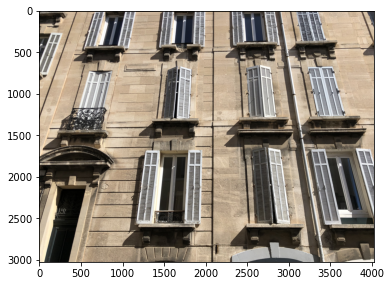

In [15]:
# Load and dispay the image
image = io.imread(os.path.join(VP_IMG_FOLDER, SAMPLE_IMG))
imshow(image)

First of all, from the input image we generate the edge detection

In [16]:
gray_img, edges, lines = generate_edges(image)
locations, directions, strengths = vector_representation(lines)

## [OPTIONAL] Analysis & Plots

In [17]:
print(f"Number of lines found: {len(lines)}")
print("\nLines sample:")
lines[:3]

Number of lines found: 27667

Lines sample:


[((2792, 953), (2786, 896)),
 ((2839, 2424), (2838, 2411)),
 ((1217, 2090), (1222, 2090))]

GRAYSCALE IMAGE


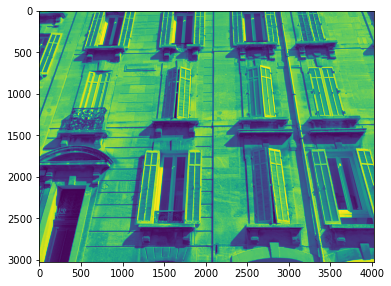

EDGES


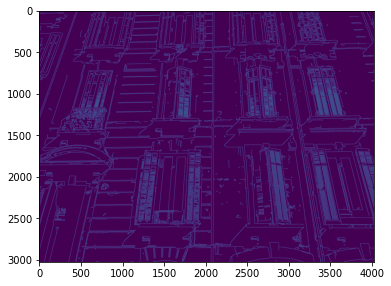

In [18]:
print("GRAYSCALE IMAGE")
imshow(gray_img)
print("EDGES")
imshow(edges)

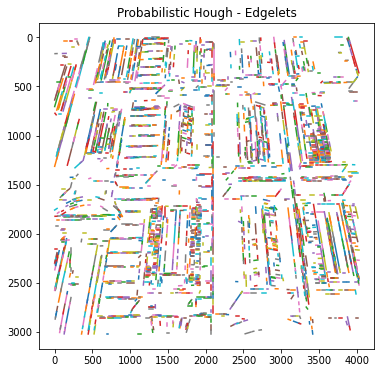

In [19]:
arg_sort = np.argsort(-strengths)
sample_lines = np.take(lines, arg_sort[:3000], axis=0)
fig = plt.figure(figsize=(6,6))
for line in sample_lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.gca().invert_yaxis()
plt.title('Probabilistic Hough - Edgelets')
plt.show()

## Vanishing Point generation

In [20]:
# We generate the first best vanishing point
# With 2000 iterations and a threshold of 5 degrees
best_vp = ransac(
    locations,
    directions,
    strengths,
    num_ransac_iter=2000,
    threshold_inlier=5
)

Current best model has 25180.053822241036 votes at iteration 1
Current best model has 74815.29426170507 votes at iteration 2
Current best model has 113818.20222786446 votes at iteration 6
Current best model has 113848.84976576905 votes at iteration 62
Current best model has 114498.4667989533 votes at iteration 76
Current best model has 115335.88057767993 votes at iteration 98


/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in arccos
/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


Current best model has 115735.67962935465 votes at iteration 275
Current best model has 115741.81039153352 votes at iteration 658


In [21]:
# We remove all edges complying to this vanishing point with a angle lower than 10 degrees
remaining_location, remaining_directions, remaining_strengths = remove_compliant_edgelets(
    best_vp,
    locations,
    directions,
    strengths,
    10
)

In [22]:
# We generate the second best vanishing point on a diminushed edgelet set
second_best_vp = ransac(
    remaining_location,
    remaining_directions,
    remaining_strengths,
    num_ransac_iter=2000,
    threshold_inlier=5
)

/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in arccos
/Users/walid/.local/share/virtualenvs/Pericolo-dlbZ2Y7z/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


Current best model has 113696.47983558655 votes at iteration 0
Current best model has 114450.30425406875 votes at iteration 18
Current best model has 114663.09895526074 votes at iteration 167
Current best model has 114898.1053485365 votes at iteration 546
Current best model has 114958.21175806879 votes at iteration 1275


## Perspective correction

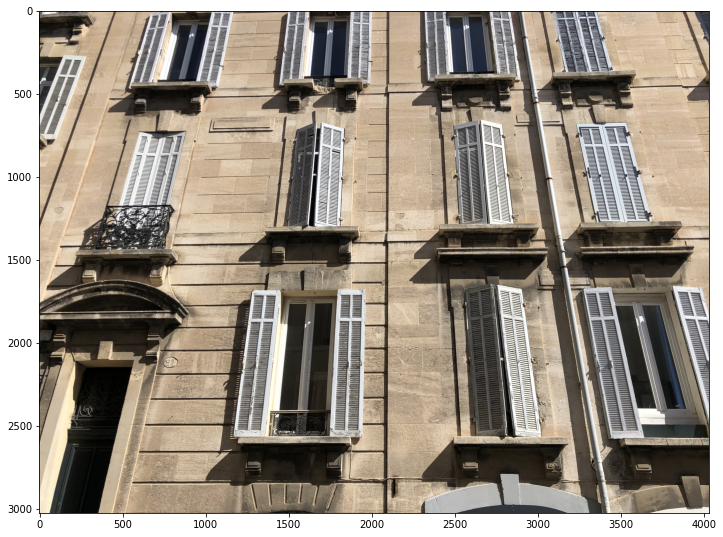

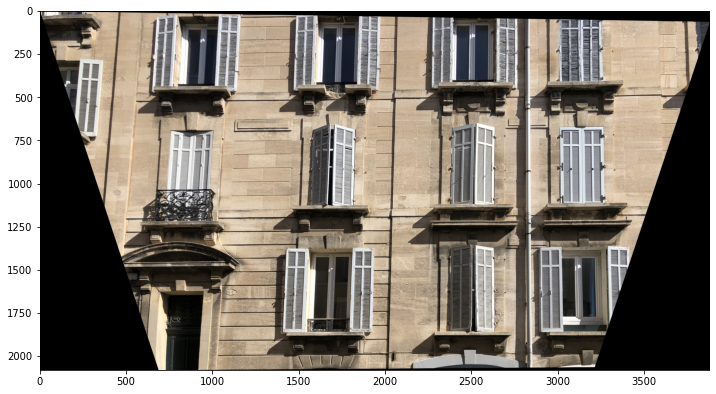

In [23]:
# We warp the image with thanks to our newly found vanishing points
warped_image = warp_image(image, best_vp, second_best_vp, clip=True, clip_factor=3)
imshow(image, (12, 12))
imshow(warped_image, (12, 12))